In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.special import lambertw
from scipy import integrate


import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 6.5]

In [2]:
j_to_ev = 6.242e18
hbar = 1.0546e-34 

thickness = 600e-9 #m, i.e. 600 nm

b = 0.286e-9 #meters
c_t = 3040 #m/s
c_l = 6420 #m/s
mu_f = 26e9 #N/ms i.e. 24 GPa
mu_s = 51e9#51e9 #silicon shear modulus, i.e. 60 GPa
rho_f = 2.7e3 # kg/m^3
gamma = 1.78
delta = 340e-6 / j_to_ev #al bandgap

In [3]:
def get_omega_ana(x, v):
    A_factor = c_t**2 * 2 * (mu_s - mu_f)/(mu_s + mu_f)
    B_factor = c_t/(gamma * b)
    
    lambertw_arg = -2 * A_factor * B_factor**-2 * x**-2
    
    exp_arg = 0.5 * lambertw(lambertw_arg, -1)
    
    return np.abs(B_factor * np.exp(exp_arg))

def get_ddt_omega_ana(x, v):
    mu_ratio = (mu_s - mu_f)/(mu_s + mu_f)
    A_term = c_t/(gamma * b)
    B_term = -4 * gamma**2 * b**2 * mu_ratio
    
    numerator = -1 * A_term * v * np.exp(0.5 * lambertw(B_term * x**-2, -1)) * lambertw(B_term * x**-2, -1)
    denominator = x * lambertw(B_term * x**-2, -1) + x
    
    return numerator/denominator

def get_force(x, v, omega, sigma, lgc_diagnostics=False):
    force_stress = sigma * b
    
    force_interface = mu_f * b**2 * ((mu_s - mu_f)/(mu_s + mu_f)) * x**-1 * (4 * np.pi)**-1
    force_radiation = -mu_f * b**2 * v * omega / (8 * c_t**2)
    relativistic = 1.0#(1 - v**2 * c_t**-2)**-0.5
    
    if lgc_diagnostics:
        print("Stress force: " + str(force_stress))
        print("Interface force: " + str(force_interface))
        print("Radiation force: " + str(force_radiation))
        print(" ")
    
    return (force_stress + force_interface + force_radiation)

def get_mass(x, v, omega):
    term_1 = mu_f * b**2 / (4 * np.pi * c_t**2)
    term_2 = np.log(c_t/(gamma * omega * b))
    
    return term_1 * term_2

def get_ddt_mass(x, v, a, omega):
    term_1 = mu_f * b**2 / (4 * np.pi * c_t**2)
    ddt_omega = get_ddt_omega_ana(x,v)
        
    return term_1 * -1 * ddt_omega * omega**-1

def get_radiated_power(x, v, a, omega, sigma):
    force_radiation = mu_f * b**2 * v * omega /(8 * c_t**2)
    force_total = get_force(x, v, omega, sigma)
    
    dmdt=get_ddt_mass(x, v, a, omega)
    dpdt_radiation = 0.5*v**2 * dmdt
    
    return (force_radiation * v) - (dpdt_radiation)

In [4]:
#overall stress 
sigma = -45e6 #N/ms i.e. 60 MPa, resolved
x_0 = 50e-9
v_0 = 0.0
a_0 = 0.0
omega_0 = get_omega_ana(x_0, v_0)
mass_0 = get_mass(x_0, v_0, omega_0)

l = 100e-9 # i.e. 100 nm, length of dislocation

stress_energy = -sigma * x_0 * l * b
kinetic_energy = 0.5 * mass_0 * v_0**2 * l
stress_energy_ev = stress_energy * j_to_ev
kinetic_energy_ev = kinetic_energy * j_to_ev
effective_x_start = -kinetic_energy/(sigma * l * b) + x_0

print("Potential stress energy (eV): " + str(stress_energy_ev))
print("Kinetic energy (eV): " + str(kinetic_energy_ev))
print("Total energy (ev): " + str(stress_energy_ev + kinetic_energy_ev))
print("Effective x start: " + str(effective_x_start*1e9) + " nm")

Potential stress energy (eV): 401.6727
Kinetic energy (eV): 0.0
Total energy (ev): 401.6727
Effective x start: 50.0 nm


In [5]:
tlim = 1e-10
max_step_ = 5e-15

#r = x, v
def f(t, r):
    x, v = r
        
    omega = get_omega_ana(x, v)
    f = get_force(x, v, omega, sigma)
    m = get_mass(x, v, omega)
    a = f/m# - v/m * ddt_m
    return v, a



sol = integrate.solve_ivp(f, (0, tlim), (x_0, v_0), t_eval=np.arange(0, tlim, max_step_),
                          max_step= max_step_, method='BDF')
#print(sol)
t_arr = sol.t
x_arr = sol.y[0]
v_arr = sol.y[1]

i = 1
a_arr = np.zeros_like(v_arr)
while i < len(v_arr) - 1:
    a_arr[i] = (v_arr[i+ 1] - v_arr[i - 1])/(t_arr[i + 1] - t_arr[i - 1])
    i += 1

omega_arr = get_omega_ana(x_arr, v_arr)
rad_p_arr = get_radiated_power(x_arr, v_arr, a_arr, omega_arr, sigma)

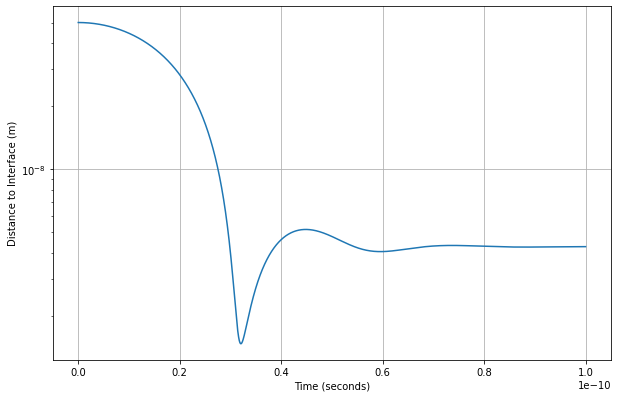

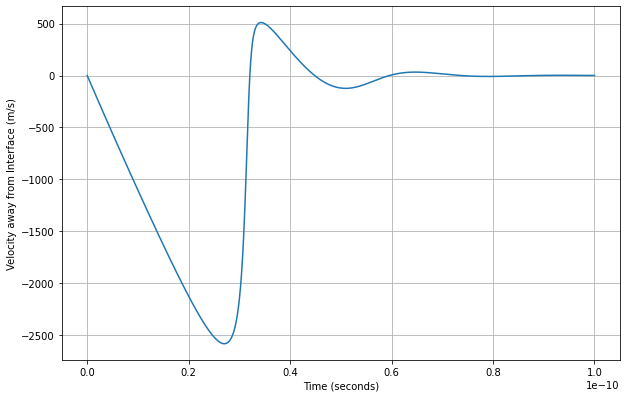

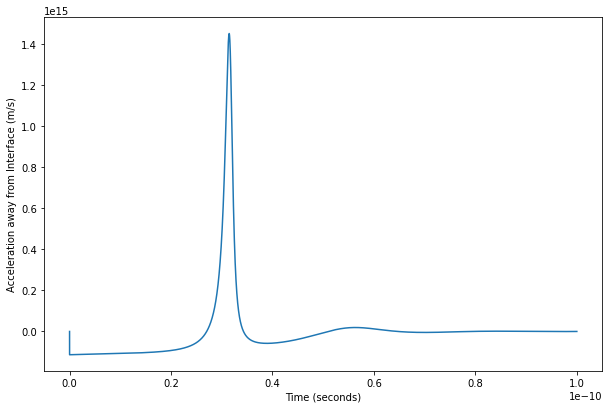

84.36237880150914
Change in Potential Energy: 282.9827634972692 eV


In [6]:
plt.plot(t_arr, x_arr)
plt.yscale('log')
plt.grid()
plt.xlabel("Time (seconds)")
plt.ylabel("Distance to Interface (m)")
plt.show()

plt.plot(t_arr, v_arr)
plt.grid()
plt.xlabel("Time (seconds)")
plt.ylabel("Velocity away from Interface (m/s)")
plt.show()


plt.plot(t_arr, a_arr)
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration away from Interface (m/s)")
plt.show()


#print("X end: " + str(x_arr[-1]))
delta_pe = -1*(x_arr[0] - x_arr[-1]) * sigma * l * b * j_to_ev
#print("Stress delta PE: " + str(delta_pe))
delta_pe += kinetic_energy_ev
delta_pe += l * mu_f * b**2 * ((mu_s - mu_f)/(mu_s + mu_f)) * (4 * np.pi)**-1 * np.log(x_arr[-1]/x_arr[0]) * j_to_ev
print(l * mu_f * b**2 * ((mu_s - mu_f)/(mu_s + mu_f)) * (4 * np.pi)**-1 * np.log(x_arr[0]/x_arr[-1])*j_to_ev)
print("Change in Potential Energy: " + str(delta_pe) + " eV")

/home/roger/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


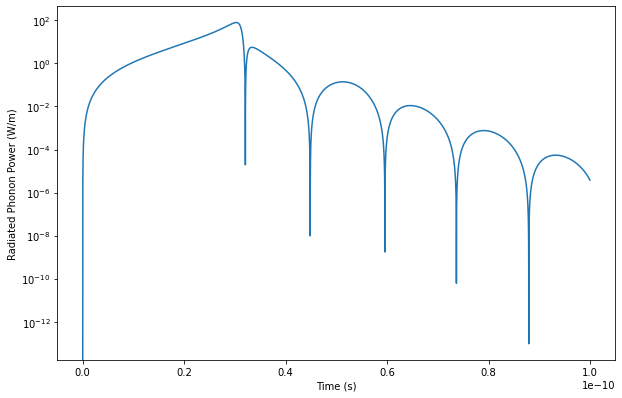

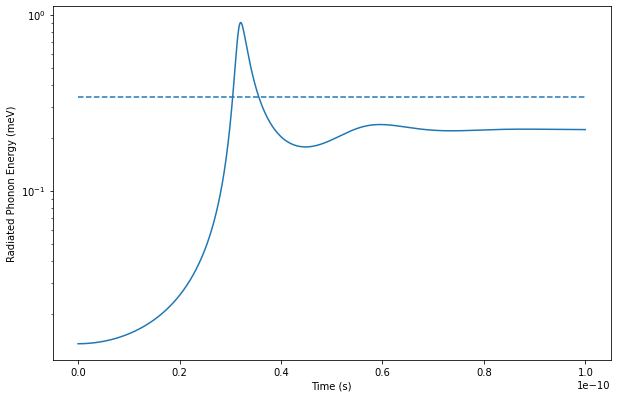

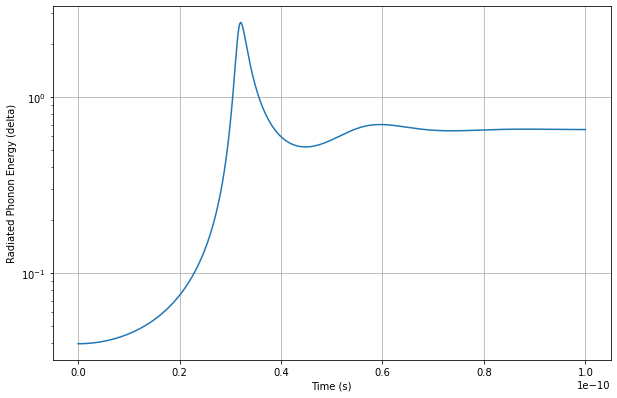

In [7]:



plt.plot(t_arr, rad_p_arr)
plt.xlabel("Time (s)")
plt.ylabel("Radiated Phonon Power (W/m)")
plt.yscale('log')
plt.show()


plt.plot(t_arr, omega_arr * hbar * j_to_ev*1e3)
plt.hlines(delta * j_to_ev * 1e3, min(t_arr), max(t_arr), linestyle = '--')
plt.xlabel("Time (s)")
plt.ylabel("Radiated Phonon Energy (meV)")
plt.yscale('log')
plt.show()

plt.plot(t_arr, omega_arr * hbar/delta)
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Radiated Phonon Energy (delta)")
plt.yscale('log')
plt.show()


#print("Initial potential energy: " + str(initial_pe * j_to_ev) + " eV")
#print("Delta PE: " + str(delta_pe) + " eV")
#print("Integrated PE change: " + str(pe_change_tot*j_to_ev) + " eV")
#print("Total radiated energy: " + str(rad_energy_tot * j_to_ev) + " eV")
#print("Above gap radiated energy: " + str(rad_energy_above_gap * j_to_ev) + " eV")
#print("Above gap forward radiated energy: " + str(rad_energy_above_gap_forward * j_to_ev) + " eV")
#print("Fraction above gap radiated forward: " + str(rad_energy_above_gap_forward/rad_energy_above_gap))

/home/roger/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


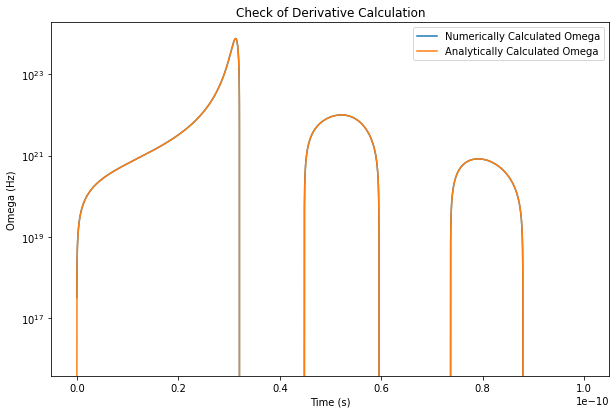

In [8]:
ddt_omega_arr_ana = get_ddt_omega_ana(x_arr, v_arr)
dt = t_arr[1] - t_arr[0]
ddt_omega_arr = (omega_arr[2:] - omega_arr[:-2]) / (2*dt)

plt.plot(t_arr[:-2], ddt_omega_arr, label = "Numerically Calculated Omega")
plt.plot(t_arr, ddt_omega_arr_ana, label = "Analytically Calculated Omega")
plt.yscale('log')
plt.ylabel("Omega (Hz)")
plt.xlabel("Time (s)")
plt.legend()
plt.title("Check of Derivative Calculation")
plt.show()

In [9]:
v_arr_negative = (v_arr<0.0)
v_arr_positive = (v_arr>0.0)
dif_v_arr = np.diff((v_arr_negative))

/home/roger/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


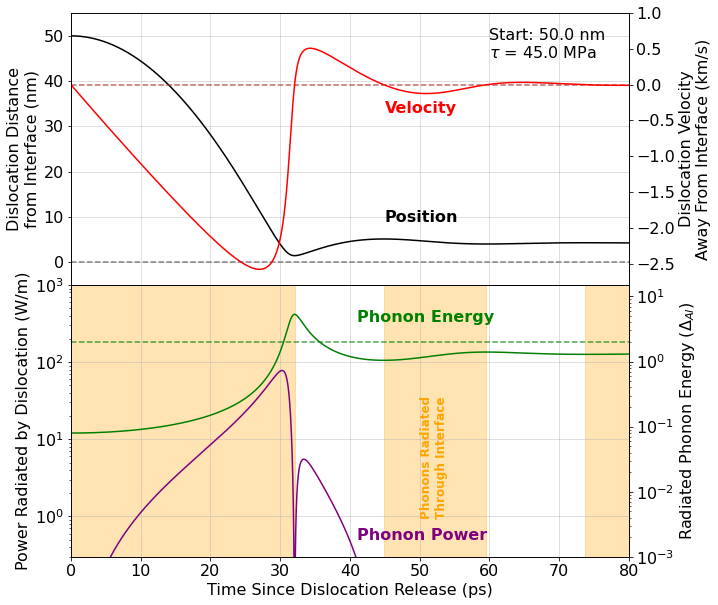

In [10]:
font = {'family': 'normal',
       'weight': 'normal',
       'size': 16}
plt.rc('font', **font)
mpl.rcParams['figure.figsize'] = [10, 10]

fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.plot(t_arr*1e12, x_arr*1e9, color = 'black')
#ax1.set_yscale('log')
ax1b = ax1.twinx()
ax1b.plot([0, max(t_arr*1e12)], [0,0], color = 'brown', linestyle = '--', alpha = 0.7)
ax1b.plot(t_arr*1e12, v_arr*1e-3, color = 'red')
ax1.plot([0, max(t_arr*1e12)], [0,0], color = 'grey', linestyle = '--')
ax1b.set_ylim(-2.8, 1)
ax1.set_ylim(-5, 55)
ax1.set_ylabel("Dislocation Distance\nfrom Interface (nm)")
ax1b.set_ylabel("Dislocation Velocity\nAway From Interface (km/s)")
ax1.text(45, 9, "Position", color = 'black', fontweight='bold', rotation = 0)
ax1b.text(45, -0.4, "Velocity", color = 'Red', fontweight='bold', rotation = 0)
ax1.text(60, 45,
         "Start: " + str(x_0*1e9) + " nm \n" + r'$\tau$ = ' + str(sigma*-1e-6) + " MPa",
         color = 'black', fontweight='normal', rotation = 0)
#ax1.set_xlabel("Time Since Dislocation Release (ps)")
ax1.grid(alpha = 0.5)


ax2.plot(t_arr*1e12, rad_p_arr, color = 'purple')
ax2.set_xlabel("Time Since Dislocation Release (ps)")
ax2b = ax2.twinx()
ax2b.plot(t_arr*1e12, omega_arr * hbar/(0.5*delta), color = 'green')
ax2b.plot([0, max(t_arr*1e12)], [2,2], color = 'green', linestyle = '--', alpha = 0.7)
ax2.set_xlim(0, 80)
ax2.set_xlabel("Time Since Dislocation Release (ps)")
ax2.set_ylabel("Power Radiated by Dislocation (W/m)")
ax2b.set_ylabel(r"Radiated Phonon Energy ($\Delta_{Al}$)")
ax2.set_yscale('log')
ax2.set_ylim(3e-1, 1e3)
ax2b.set_yscale('log')
ax2b.set_ylim(1e-3, 15e0)
ax2.text(41, 0.5e0, "Phonon Power", color= 'purple', fontweight = 'bold')
ax2b.text(41, 4, "Phonon Energy", color= 'green', fontweight = 'bold')
#ax2b.text(115, 15, "Dislocation Width: "  +str(l*1e9) + " nm")
ax2.grid(alpha = 0.5)

i = 0
while i < len(t_arr[:-1][dif_v_arr]) - 1:
    if i % 2 == 0:
        ax2.fill_between([t_arr[:-1][dif_v_arr][i]*1e12, t_arr[:-1][dif_v_arr][i + 1]*1e12],
                         [1e-1, 1e-1], [3e3, 3e3],
                        color = 'orange', alpha = 0.3)
    i += 1
ax2.text(50, 0.1e1, "Phonons Radiated\nThrough Interface", color= 'orange', fontsize = 12, 
         fontweight = 'bold', rotation = 90)

plt.subplots_adjust(hspace=0)

#fig.savefig("DislocationMotion_3.pdf", bbox_inches='tight')
plt.show()

/home/roger/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6653: ComplexWarning: Casting complex values to real discards the imaginary part
  tops = np.array(tops, float)  # causes problems later if it's an int
/home/roger/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6653: ComplexWarning: Casting complex values to real discards the imaginary part
  tops = np.array(tops, float)  # causes problems later if it's an int
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


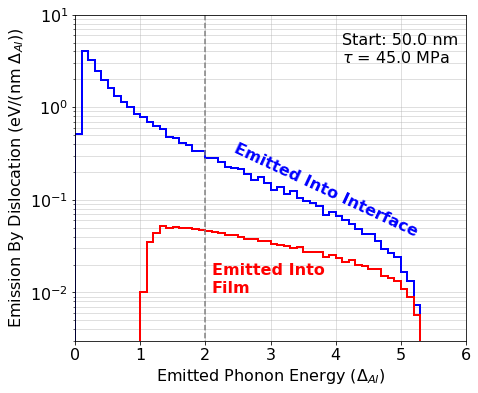

In [11]:
font = {'family': 'normal',
       'weight': 'normal',
       'size': 16}
plt.rc('font', **font)
mpl.rcParams['figure.figsize'] = [7, 6]

bin_width = 0.1
bins = np.arange(0, 6, bin_width)


fig, (ax1) = plt.subplots(1, sharex=True)


weights_all = rad_p_arr*max_step_* j_to_ev * 1e-9 / bin_width
weights_forward = weights_all * np.asarray([v_arr < 0.0], dtype = np.float)[0]
weights_backward = weights_all * np.asarray([v_arr > 0.0], dtype = np.float)[0]


vals_forward, bins_, _ = ax1.hist(omega_arr * hbar/(0.5*delta),
         weights=weights_forward,
        histtype='step', bins = bins, linewidth = 2.0, color = 'Blue')
vals_backward, bins_, _ = ax1.hist(omega_arr * hbar/(0.5*delta),
         weights=weights_backward,
        histtype='step', bins = bins, linewidth = 2.0, color = 'Red')
ax1.plot([2,2],[1e-6, 1e2], color = 'grey', linestyle = '--')
ax1.set_yscale('log')
ax1.set_ylabel("Emission By Dislocation (eV/(nm $\Delta_{Al}$))")
ax1.set_xlabel(r"Emitted Phonon Energy ($\Delta_{Al}$)")
ax1.text(2.4, 0.04, "Emitted Into Interface", color = 'Blue', fontweight = 'bold', rotation = 335)
ax1.text(2.1, 0.01, "Emitted Into\nFilm", color = 'Red', fontweight = 'bold', rotation = 0)
ax1.text(4.1, 1.95,
         "Start: " + str(x_0*1e9) + " nm \n" + r'$\tau$ = ' + str(sigma*-1e-6) + " MPa\n",#+ "Width: "  +str(l*1e9) + " nm",
         color = 'black', fontweight='normal', rotation = 0)
ax1.grid(alpha = 0.5, which = 'both')
ax1.set_ylim(3e-3, 10e0)
#plt.ylim(10e-1, 9e1)
ax1.set_xlim(0, 6)


#ax1b = ax1.twinx()

ratio_forward = np.ones_like(bins_)
i = 0
while i < len(bins_):
    delta_lim = bins_[i]
    if sum(vals_forward[bins_[1:] > delta_lim]) is not 0:
        ratio_forward[i] = sum(vals_forward[bins_[1:] > delta_lim])/(sum(vals_backward[bins_[1:] > delta_lim]) + sum(vals_forward[bins_[1:] > delta_lim]))
    i += 1
#ax1b.plot(bins_, ratio_forward, color = 'black')
#ax1b.set_ylim(0.0, 1.2)
#ax1b.set_ylabel("Fraction of Energy Emitted\n Into Interface Above Cutoff ")
#ax1b.grid(color = 'black')
#print(ratio_forward)

#plt.savefig("DislocationEmissionSpectrum_3.pdf", bbox_inches='tight')
plt.show()

In [12]:
print("Total Radiated Phonon Energy: " + str(sum(np.abs(weights_all))*bin_width*l*1e9))
print("Total Into Crystal Phonon Energy: " + str(sum(vals_forward[bins_[1:] > 0.0])*bin_width*l*1e9))
print("Total Into Film Phonon Energy: " + str(sum(vals_backward[bins_[1:] > 0.0])*bin_width*l*1e9))
print(" ")

delta_lim = 2
print("Above " + str(delta_lim) + " delta:")
print("Energy Radiated Into Crystal: " + str(sum(vals_forward[bins_[1:] > delta_lim])*bin_width*l*1e9))
print("Energy Radiated Into Film: " + str(sum(vals_backward[bins_[1:] > delta_lim])*bin_width*l*1e9))
print("Fraction of Energy Radiated into Crystal: " + str(sum(vals_forward[bins_[1:] > delta_lim])/(sum(vals_backward[bins_[1:] > delta_lim]) + sum(vals_forward[bins_[1:] > delta_lim]))))


Total Radiated Phonon Energy: 282.9822026597961
Total Into Crystal Phonon Energy: 269.55033226977815
Total Into Film Phonon Energy: 13.43187039001686
 
Above 2 delta:
Energy Radiated Into Crystal: 36.55103539877203
Energy Radiated Into Film: 9.06682739206734
Fraction of Energy Radiated into Crystal: 0.8012439242574935


In [13]:
def get_radiated_energies_ev(sigma, x_0, v_0, tlim=5e-10, max_step=1e-12):
    nosolution = True
    k = 0
    while nosolution:
        a_0 = 0.0
        omega_0 = get_omega_ana(x_0, v_0)
        mass_0 = get_mass(x_0, v_0, omega_0)

        l = 100e-9 # i.e. 100 nm, length of dislocation

        #r = x, v
        def f(t, r):
            x, v = r

            omega = get_omega_ana(x, v)
            f = get_force(x, v, omega, sigma)
            m = get_mass(x, v, omega)
            a = f/m# - v/m * ddt_m
            return v, a



        sol = integrate.solve_ivp(f, (0, tlim), (x_0, v_0), t_eval=np.arange(0, tlim, 1e-14),
                                  max_step=max_step)
        #print(sol)
        t_arr = sol.t
        x_arr = sol.y[0]
        v_arr = sol.y[1]

        i = 1
        a_arr = np.zeros_like(v_arr)
        while i < len(v_arr) - 1:
            a_arr[i] = (v_arr[i+ 1] - v_arr[i - 1])/(t_arr[i + 1] - t_arr[i - 1])
            i += 1

        omega_arr = get_omega_ana(x_arr, v_arr)
        #rad_p_arr = get_radiated_power_2(x_arr, v_arr, a_arr, omega_arr)
        rad_p_arr = get_radiated_power(x_arr, v_arr, a_arr, omega_arr, sigma)

        dt = t_arr[1] - t_arr[0]
        energy_total = sum(np.real(rad_p_arr)) * dt * l * j_to_ev
        
        energy_ag = 0.0
        i = 0
        while i < len(rad_p_arr):
            if (omega_arr[i] * hbar > delta):
                energy_ag += rad_p_arr[i] * dt * l * j_to_ev
            i += 1
        
        energy_forward = 0.0
        i = 0
        while i < len(rad_p_arr):
            if (omega_arr[i] * hbar > delta) and (v_arr[i] < 0.0):
                energy_forward += rad_p_arr[i] * dt * l * j_to_ev
            i += 1

        if k > 12:
            print("Couldn't reach good solution")
            return np.nan, np.nan, np.nan
            
        if (x_arr[-2]) < 0.0:
            max_step /= 1.9
            print("Retrying with smaller step size " + str(max_step))
        elif np.abs(v_arr[-2]) > 1.0:
            tlim *= 2.1
            print("Retrying with longer time window " + str(tlim))
        else:
            #print("Found solution")
            return energy_total, energy_ag, energy_forward
            
        k += 1
    
    return energy_total, energy_ag, energy_forward

In [14]:
tlim = 1e-10
max_step = 100e-15
print("Time limit: " + str(tlim))
print("Time step: " + str(max_step))

x_arr_2d = np.arange(10e-9, 410e-9, 2.5e-9)
#print(x_arr_2d)
sigma_arr_2d = np.arange(-25e6, -65e6, -2.5e6)
#print(sigma_arr_2d)
print(" ")

energies_rad_2d_arr = np.zeros([len(x_arr_2d), len(sigma_arr_2d)])
energies_ag_2d_arr = np.zeros([len(x_arr_2d), len(sigma_arr_2d)])
energies_forward_2d_arr = np.zeros([len(x_arr_2d), len(sigma_arr_2d)])

v_0 = 0.0

i = 0
while i < len(x_arr_2d):
    j = 0
    while j < len(sigma_arr_2d):
        x0 = x_arr_2d[i]
        sigma = sigma_arr_2d[j]
        print("Event: " + str(x0) + ", " + str(sigma))
        
        maxstep_attempt = max_step
        tlim_attempt = tlim
        #print("Got above gap energy")
        result_tot_energy, result_ag_energy, result_forward_energy = get_radiated_energies_ev(sigma_arr_2d[j], x_arr_2d[i], v_0,
                                                          tlim=tlim_attempt, 
                                                          max_step=maxstep_attempt)
        #print("Got forward energy")
        
        
        energies_rad_2d_arr[i][j] = result_tot_energy
        energies_ag_2d_arr[i][j] = result_ag_energy
        energies_forward_2d_arr[i][j] = result_forward_energy
        j += 1
    print("Done with x " + str(i) + " of " + str(len(x_arr_2d)))
    print(" ")
    i += 1

Time limit: 1e-10
Time step: 1e-13
 
Event: 1e-08, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1e-08, -27500000.0
Event: 1e-08, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1e-08, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1e-08, -35000000.0
Event: 1e-08, -37500000.0
Event: 1e-08, -40000000.0
Event: 1e-08, -42500000.0
Event: 1e-08, -45000000.0
Event: 1e-08, -47500000.0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


Event: 1e-08, -50000000.0
Event: 1e-08, -52500000.0
Event: 1e-08, -55000000.0
Event: 1e-08, -57500000.0
Event: 1e-08, -60000000.0
Event: 1e-08, -62500000.0
Done with x 0 of 160
 
Event: 1.25e-08, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.25e-08, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.25e-08, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.25e-08, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.25e-08, -35000000.0
Event: 1.25e-08, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.25e-08, -40000000.0
Event: 1.25e-08, -42500000.0
Event: 1.25e-08, -45000000.0
Event: 1.25e-08, -47500000.0
Event: 1.25e-08, -50000000.0
Event: 1.25e-08, -52500000.0
Event: 1.25e-08, -55000000.0
Event: 1.25e-08, -57500000.0
Event: 1.25e-08, -60000000.0
Event: 1.25e-08, -62500000.0
Done with x 1 of 160
 
Event: 1.5e-08, -25000000.0
Retrying with longer time 

Retrying with longer time window 2.1000000000000002e-10
Event: 3.249999999999999e-08, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.249999999999999e-08, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.249999999999999e-08, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.249999999999999e-08, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.249999999999999e-08, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.249999999999999e-08, -42500000.0
Event: 3.249999999999999e-08, -45000000.0
Event: 3.249999999999999e-08, -47500000.0
Event: 3.249999999999999e-08, -50000000.0
Event: 3.249999999999999e-08, -52500000.0
Event: 3.249999999999999e-08, -55000000.0
Event: 3.249999999999999e-08, -57500000.0
Event: 3.249999999999999e-08, -60000000.0
Event: 3.249999999999999e-08, -62500000.0
Done with x 9 of 160
 
Event: 3.4999999999999996e-08, -25000000.0
Retrying w

Event: 4.9999999999999985e-08, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 4.9999999999999985e-08, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 4.9999999999999985e-08, -45000000.0
Event: 4.9999999999999985e-08, -47500000.0
Event: 4.9999999999999985e-08, -50000000.0
Event: 4.9999999999999985e-08, -52500000.0
Event: 4.9999999999999985e-08, -55000000.0
Event: 4.9999999999999985e-08, -57500000.0
Event: 4.9999999999999985e-08, -60000000.0
Event: 4.9999999999999985e-08, -62500000.0
Done with x 16 of 160
 
Event: 5.249999999999999e-08, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 5.249999999999999e-08, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 5.249999999999999e-08, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 5.249999999999999e-08, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 5.249999999999999e-08, -35000000.0


Retrying with longer time window 2.1000000000000002e-10
Event: 6.749999999999998e-08, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 6.749999999999998e-08, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 6.749999999999998e-08, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 6.749999999999998e-08, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 6.749999999999998e-08, -47500000.0
Event: 6.749999999999998e-08, -50000000.0
Event: 6.749999999999998e-08, -52500000.0
Event: 6.749999999999998e-08, -55000000.0
Event: 6.749999999999998e-08, -57500000.0
Event: 6.749999999999998e-08, -60000000.0
Event: 6.749999999999998e-08, -62500000.0
Done with x 23 of 160
 
Event: 6.999999999999998e-08, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 6.999999999999998e-08, -27500000.0
Retrying with longer time window 2.1000

Event: 8.249999999999998e-08, -62500000.0
Done with x 29 of 160
 
Event: 8.499999999999997e-08, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 8.499999999999997e-08, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 8.499999999999997e-08, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 8.499999999999997e-08, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 8.499999999999997e-08, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 8.499999999999997e-08, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 8.499999999999997e-08, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 8.499999999999997e-08, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 8.499999999999997e-08, -45000000.0
Retrying with longer time window 2.1000000000000002e-

Retrying with longer time window 2.1000000000000002e-10
Event: 9.999999999999997e-08, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 9.999999999999997e-08, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 9.999999999999997e-08, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 9.999999999999997e-08, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 9.999999999999997e-08, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 9.999999999999997e-08, -47500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 9.999999999999997e-08, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 9.999999999999997e-08, -52500000.0
Event: 9.999999999999997e-08, -55000000.0
Event: 9.999999999999997e-08, -57500000.0
Event: 9.999999999999997e-08, -60000000.0
Event: 9.999999999999997e-08, -62500000.0
Done with x 36 of 160
 
Event: 1.024999999999999

Event: 1.1499999999999997e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.1499999999999997e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.1499999999999997e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.1499999999999997e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.1499999999999997e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.1499999999999997e-07, -47500000.0
Event: 1.1499999999999997e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.1499999999999997e-07, -52500000.0
Event: 1.1499999999999997e-07, -55000000.0
Event: 1.1499999999999997e-07, -57500000.0
Event: 1.1499999999999997e-07, -60000000.0
Event: 1.1499999999999997e-07, -62500000.0
Done with x 42 of 160
 
Event: 1.1749999999999996e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time

Event: 1.2999999999999997e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.2999999999999997e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.2999999999999997e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.2999999999999997e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.2999999999999997e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.2999999999999997e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.2999999999999997e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.2999999999999997e-07, -47500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.2999999999999997e-07, -50000000.0
Event: 1.2999999999999997e-07, -52500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.2999999999999997e-07, -55000000.0
Event: 1.29999999999999

Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 1.4499999999999996e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 1.4499999999999996e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.4499999999999996e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.4499999999999996e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.4499999999999996e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.4499999999999996e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.4499999999999996e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.4499999999999996e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.4499999999999996e-07, -47500000.0

Retrying with longer time window 2.1000000000000002e-10
Event: 1.5749999999999997e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.5749999999999997e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.5749999999999997e-07, -47500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.5749999999999997e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.5749999999999997e-07, -52500000.0
Event: 1.5749999999999997e-07, -55000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.5749999999999997e-07, -57500000.0
Event: 1.5749999999999997e-07, -60000000.0
Event: 1.5749999999999997e-07, -62500000.0
Done with x 59 of 160
 
Event: 1.5999999999999995e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 1.5999999999999995e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10


Retrying with longer time window 4.410000000000001e-10
Event: 1.7249999999999996e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 1.7249999999999996e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.7249999999999996e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.7249999999999996e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.7249999999999996e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.7249999999999996e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.7249999999999996e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.7249999999999996e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.7249999999999996e-07, -47500000.0
Retrying with longer time window 2.1000000000000002e-10

Retrying with longer time window 2.1000000000000002e-10
Event: 1.8499999999999995e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.8499999999999995e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.8499999999999995e-07, -47500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.8499999999999995e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.8499999999999995e-07, -52500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.8499999999999995e-07, -55000000.0
Event: 1.8499999999999995e-07, -57500000.0
Event: 1.8499999999999995e-07, -60000000.0
Event: 1.8499999999999995e-07, -62500000.0
Done with x 70 of 160
 
Event: 1.8749999999999995e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 1.8749999999999995e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10


Event: 1.9749999999999996e-07, -52500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.9749999999999996e-07, -55000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.9749999999999996e-07, -57500000.0
Event: 1.9749999999999996e-07, -60000000.0
Event: 1.9749999999999996e-07, -62500000.0
Done with x 75 of 160
 
Event: 1.9999999999999994e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 1.9999999999999994e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 1.9999999999999994e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 1.9999999999999994e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 1.9999999999999994e-07, -35000000.0
Retrying with longer time window 2.1000000000

Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.1249999999999995e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.1249999999999995e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.1249999999999995e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.1249999999999995e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.1249999999999995e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.1249999999999995e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.1249999999999995e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.1249999999999995e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.1249999999999995e-07, -47500000.0

Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.2499999999999994e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.2499999999999994e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.2499999999999994e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.2499999999999994e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.2499999999999994e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.2499999999999994e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.2499999999999994e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.2499999999999994e-07, -45000000.0
Retrying with longer time window 2.10000000

Retrying with longer time window 2.1000000000000002e-10
Event: 2.3499999999999995e-07, -62500000.0
Done with x 90 of 160
 
Event: 2.3749999999999995e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.3749999999999995e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.3749999999999995e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.3749999999999995e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.3749999999999995e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.3749999999999995e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.3749999999999995e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.3749999999

Event: 2.474999999999999e-07, -57500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.474999999999999e-07, -60000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.474999999999999e-07, -62500000.0
Done with x 95 of 160
 
Event: 2.4999999999999994e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.4999999999999994e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.4999999999999994e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.4999999999999994e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.4999999999999994e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.4999999999999994e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.4999999999999994e-07, -40

Retrying with longer time window 2.1000000000000002e-10
Event: 2.5999999999999995e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.5999999999999995e-07, -52500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.5999999999999995e-07, -55000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.5999999999999995e-07, -57500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.5999999999999995e-07, -60000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.5999999999999995e-07, -62500000.0
Retrying with longer time window 2.1000000000000002e-10
Done with x 100 of 160
 
Event: 2.624999999999999e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.624999999999999e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.6249999999

Event: 2.7249999999999993e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.7249999999999993e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.7249999999999993e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.7249999999999993e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.7249999999999993e-07, -47500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.7249999999999993e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.7249999999999993e-07, -52500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.7249999999999993e-07, -55000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.7249999999999993e-07, -57500000.0
Event: 2.7249999999999993e-07, -60000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.7249999999999993e-07, -62500000.0
Retrying with longer ti

Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.849999999999999e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.849999999999999e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.849999999999999e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.849999999999999e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.849999999999999e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.849999999999999e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.849999999999999e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.849999999999999e-07, -45000000.0
Retrying with longer time window 2.1000000000000002

Retrying with longer time window 2.1000000000000002e-10
Event: 2.9499999999999993e-07, -57500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.9499999999999993e-07, -60000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 2.9499999999999993e-07, -62500000.0
Retrying with longer time window 2.1000000000000002e-10
Done with x 114 of 160
 
Event: 2.974999999999999e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.974999999999999e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.974999999999999e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.974999999999999e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 2.9

Retrying with longer time window 4.410000000000001e-10
Event: 3.074999999999999e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.074999999999999e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.074999999999999e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.074999999999999e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.074999999999999e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.074999999999999e-07, -47500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.074999999999999e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.074999999999999e-07, -52500000.0
Event: 3.074999999999999e-07, -55000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.074999999999999e-07, -57500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.074999999999

Retrying with longer time window 2.1000000000000002e-10
Done with x 123 of 160
 
Event: 3.199999999999999e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.199999999999999e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.199999999999999e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.199999999999999e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.199999999999999e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.199999999999999e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.199999999999999e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.1999

Retrying with longer time window 2.1000000000000002e-10
Event: 3.299999999999999e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.299999999999999e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.299999999999999e-07, -47500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.299999999999999e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.299999999999999e-07, -52500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.299999999999999e-07, -55000000.0
Event: 3.299999999999999e-07, -57500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.299999999999999e-07, -60000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.299999999999999e-07, -62500000.0
Retrying with longer time window 2.1000000000000002e-10
Done with x 128 of 160
 
Event: 3.324999999999999e-07, -25000000.0
Retrying with longer time window 2.1000000000000002

Event: 3.424999999999999e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.424999999999999e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.424999999999999e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.424999999999999e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.424999999999999e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.424999999999999e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.424999999999999e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.424999999999999e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.424999999999999e-07, -47500000.0
Retrying 

Event: 3.524999999999999e-07, -47500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.524999999999999e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.524999999999999e-07, -52500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.524999999999999e-07, -55000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.524999999999999e-07, -57500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.524999999999999e-07, -60000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.524999999999999e-07, -62500000.0
Retrying with longer time window 2.1000000000000002e-10
Done with x 137 of 160
 
Event: 3.549999999999999e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.549999999999999e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410

Retrying with longer time window 4.410000000000001e-10
Event: 3.649999999999999e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.649999999999999e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.649999999999999e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.649999999999999e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.649999999999999e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.649999999999999e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.649999999999999e-07, -47500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.649999999999999e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.649999999999999e-07, -52500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3

Event: 3.749999999999999e-07, -55000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.749999999999999e-07, -57500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.749999999999999e-07, -60000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.749999999999999e-07, -62500000.0
Retrying with longer time window 2.1000000000000002e-10
Done with x 146 of 160
 
Event: 3.774999999999999e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.774999999999999e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.774999999999999e-07, -30000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.774999999999999e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.774999999999999e-

Event: 3.874999999999999e-07, -32500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.874999999999999e-07, -35000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.874999999999999e-07, -37500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.874999999999999e-07, -40000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.874999999999999e-07, -42500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.874999999999999e-07, -45000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.874999999999999e-07, -47500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.874999999999999e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.874999999999999e-07, -52500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3

Event: 3.974999999999999e-07, -50000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.974999999999999e-07, -52500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.974999999999999e-07, -55000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.974999999999999e-07, -57500000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.974999999999999e-07, -60000000.0
Retrying with longer time window 2.1000000000000002e-10
Event: 3.974999999999999e-07, -62500000.0
Retrying with longer time window 2.1000000000000002e-10
Done with x 155 of 160
 
Event: 3.999999999999999e-07, -25000000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.999999999999999e-07, -27500000.0
Retrying with longer time window 2.1000000000000002e-10
Retrying with longer time window 4.410000000000001e-10
Event: 3.999999999999999e-07, -30000000.0
Retrying with longer time window 2.1000

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


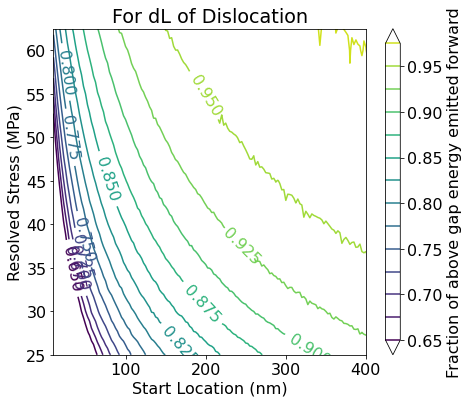

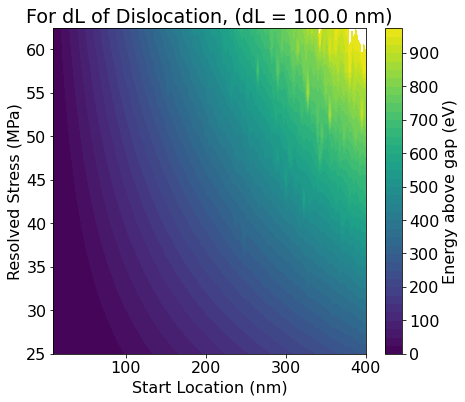

In [15]:
eff_max = 1.0
eff_min = 0.65
levels = np.arange(eff_min, eff_max, 0.025)
CS = plt.contour(x_arr_2d*1e9, sigma_arr_2d*-1e-6,
             (np.transpose(energies_forward_2d_arr))/(np.transpose(energies_ag_2d_arr)),
            vmin = eff_min, vmax = eff_max, levels = levels, extend='both')
plt.colorbar(label = "Fraction of above gap energy emitted forward")
plt.clim(eff_min, eff_max)
plt.clabel(CS)
plt.xlabel("Start Location (nm)")
plt.ylabel("Resolved Stress (MPa)")
plt.xlim(10, 400)
plt.title("For dL of Dislocation")
plt.show()

emax = 1000
levels = np.arange(0.0, emax, emax/40)
plt.contourf(x_arr_2d*1e9, sigma_arr_2d*-1e-6, (np.transpose(energies_ag_2d_arr)), 
            vmin = 0.0, vmax = emax, levels=levels)
plt.colorbar(label = "Energy above gap (eV)")
plt.clim(0.0, emax)
plt.xlabel("Start Location (nm)")
plt.ylabel("Resolved Stress (MPa)")
plt.xlim(10, 400)
plt.title("For dL of Dislocation, (dL = " + str(l*1e9) + " nm)")
plt.show()

In [16]:
alpha = 0.8#for forest dislocation
delta_h = x_arr_2d[1] - x_arr_2d[0]
print("Deltah : " + str(delta_h))

def get_width_failing_dislocation(tau):
    return alpha * mu_f * b/tau

def get_event_energy(x0, tau):
    tau_i = 0
    while sigma_arr_2d[tau_i]*-1 < tau:
        tau_i += 1
    #print("Using tau = " + str(sigma_arr_2d[tau_i]*-1e-6) + " MPa")
    
    e_tot = 0.0
    h_low = 1e-9
    i = 0
    while i < len(x_arr_2d):
        if (x_arr_2d[i] > h_low) and (x_arr_2d[i] < x0):
            width = get_width_failing_dislocation(sigma_arr_2d[tau_i]*-1)
            dx_dh_ = width/x0
            e_tot += delta_h * np.transpose(energies_forward_2d_arr)[tau_i, i]/l * dx_dh_
            #e_tot += delta_h * np.transpose(energies_forward_2d_arr)[tau_i, i]/l * dx_dh(x_arr_2d[i], sigma_arr_2d[tau_i])
        i += 1
    
    return e_tot

def get_event_efficiency(x0, tau):
    tau_i = 0
    while sigma_arr_2d[tau_i]*-1 < tau:
        tau_i += 1
    #print("Using tau = " + str(sigma_arr_2d[tau_i]*-1e-6) + " MPa")
    
    e_tot_ag = 0.0
    e_tot_forward = 0.0
    h_low = 1e-9
    i = 0
    while i < len(x_arr_2d):
        if (x_arr_2d[i] > h_low) and (x_arr_2d[i] < x0):
            width = get_width_failing_dislocation(sigma_arr_2d[tau_i]*-1)
            dx_dh_ = width/x0
            e_tot_ag += delta_h * np.transpose(energies_ag_2d_arr)[tau_i, i]/l * dx_dh_
            e_tot_forward += delta_h * np.transpose(energies_forward_2d_arr)[tau_i, i]/l * dx_dh_
            #e_tot += delta_h * np.transpose(energies_forward_2d_arr)[tau_i, i]/l * dx_dh(x_arr_2d[i], sigma_arr_2d[tau_i])
        i += 1
    
    if e_tot_ag < 0.1:
        return np.NaN
    return e_tot_forward/e_tot_ag

#print(energies_ag_2d_arr - energies_forward_2d_arr)

Deltah : 2.4999999999999992e-09


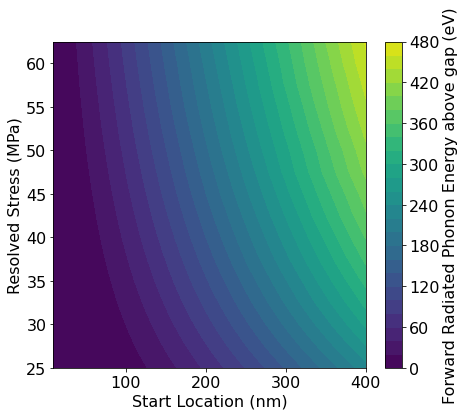

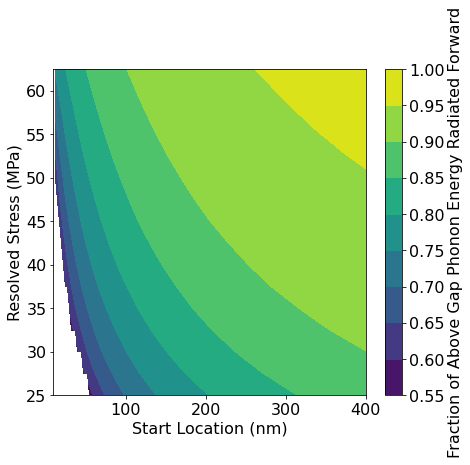

In [17]:
energies_forward_2d_arr_corrected_ = np.zeros_like(energies_ag_2d_arr)

i = 0
while i < len(x_arr_2d):
    j = 0
    while j < len(sigma_arr_2d):
        energies_forward_2d_arr_corrected_[i][j] = get_event_energy(x_arr_2d[i], -1*sigma_arr_2d[j])
        j += 1
    i += 1
    
efficiencies_corrected_ = np.zeros_like(energies_ag_2d_arr)

i = 0
while i < len(x_arr_2d):
    j = 0
    while j < len(sigma_arr_2d):
        efficiencies_corrected_[i][j] = get_event_efficiency(x_arr_2d[i], -1*sigma_arr_2d[j])
        j += 1
    i += 1
    
#print(efficiencies_corrected_)
    
from matplotlib.colors import LogNorm
    
emax = 500
levels = np.arange(0.0, emax, 20)
plt.contourf(x_arr_2d*1e9, sigma_arr_2d*-1e-6, (np.transpose(energies_forward_2d_arr_corrected_)),
             vmin = 0.0, vmax = emax, levels=levels)
plt.colorbar(label = "Forward Radiated Phonon Energy above gap (eV)")
plt.clim(0.0, emax)
plt.xlabel("Start Location (nm)")
plt.ylabel("Resolved Stress (MPa)")
#plt.ylim(10, 50)
plt.xlim(10, 400)
plt.show()

plt.contourf(x_arr_2d*1e9, sigma_arr_2d*-1e-6, (np.transpose(efficiencies_corrected_)),)
             #vmin = 0.0, vmax = emax, levels=levels)
plt.colorbar(label = "Fraction of Above Gap Phonon Energy Radiated Forward")
#plt.clim(0.0, emax)
plt.xlabel("Start Location (nm)")
plt.ylabel("Resolved Stress (MPa)")
#plt.ylim(10, 50)
plt.xlim(10, 400)
plt.show()

In [18]:
efficiencies_corrected__ = efficiencies_corrected_
efficiencies_corrected__[np.isnan(efficiencies_corrected_)] = 0

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


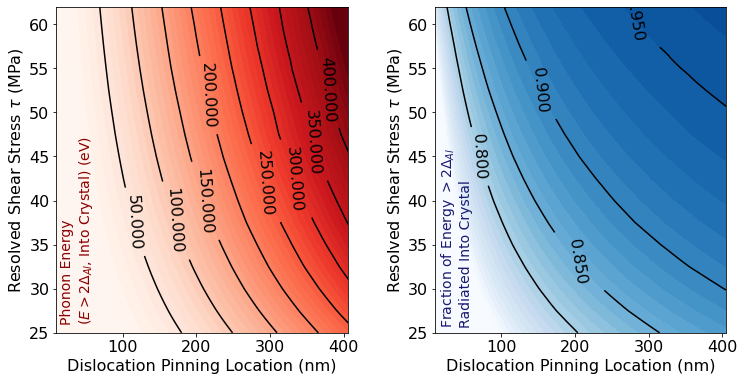

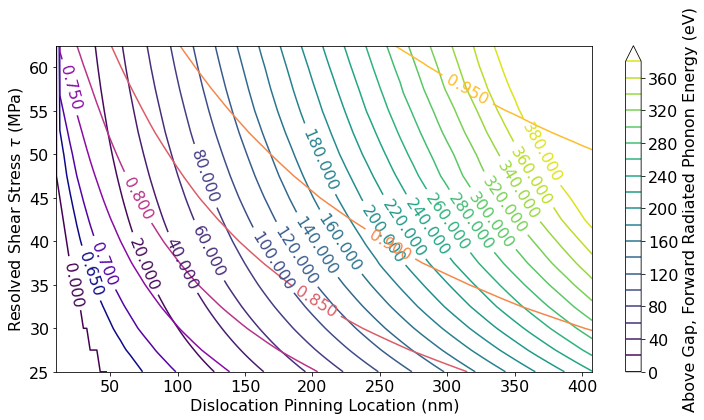

In [19]:
font = {'family': 'normal',
       'weight': 'normal',
       'size': 16}
plt.rc('font', **font)
mpl.rcParams['figure.figsize'] = [12, 6]

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=10)

e_max = 450.0
e_min = 10.0
levels = np.arange(50, e_max, 50)
ax1aplot = ax1.contour(x_arr_2d*1e9, sigma_arr_2d*-1e-6,
             #(np.transpose(energies_forward_2d_arr))/(np.transpose(energies_ag_2d_arr)),
                       np.transpose(energies_forward_2d_arr_corrected_), 
            vmin = e_min, vmax = e_max, levels = levels, extend='max', colors = 'black')# extend='max')
levels = np.arange(0, e_max, 10)
ax1bplot = ax1.contourf(x_arr_2d*1e9, sigma_arr_2d*-1e-6,
             #(np.transpose(energies_forward_2d_arr))/(np.transpose(energies_ag_2d_arr)),
                       np.transpose(energies_forward_2d_arr_corrected_), 
            vmin = e_min, vmax = e_max, levels = levels, extend='max', cmap = 'Reds')# extend='max')
#plt.colorbar(ax1bplot, label = "Phonon Energy ($E > 2\Delta_{Al}$, Into Crystal) (eV)", ax=ax1)
plt.clabel(ax1aplot)
ax1.text(15, 26.5, "Phonon Energy\n($E > 2\Delta_{Al}$, Into Crystal) (eV)",
         rotation = 90, color = 'darkred', size = 14)
#ax1.clim(e_min, e_max)
ax1.set_xlabel("Dislocation Pinning Location (nm)")
ax1.set_ylabel(r"Resolved Shear Stress $\tau$ (MPa)")
ax1.set_xlim(10, 405)
ax1.set_ylim(25, 62)

eff_min = 0.7
eff_max = 1.0
levels = np.arange(0.8, eff_max, 0.05)
ax2aplot = ax2.contour(x_arr_2d*1e9, sigma_arr_2d*-1e-6,
                       #(np.transpose(energies_forward_2d_arr_corrected)),
                       np.transpose(efficiencies_corrected__), 
             vmin = eff_min, vmax = eff_max, levels=levels, extend='both', colors = 'black')
levels = np.arange(eff_min, eff_max, 0.01)
ax2bplot = ax2.contourf(x_arr_2d*1e9, sigma_arr_2d*-1e-6,
                       #(np.transpose(energies_forward_2d_arr_corrected)),
                       np.transpose(efficiencies_corrected_), 
             vmin = eff_min, vmax = eff_max, levels=levels, extend='both', cmap = 'Blues')
#plt.colorbar(ax2bplot, label = "Fraction of Energy $> 2\Delta_{Al}$ Radiated into Crystal", ax=ax2)
#plt.clim(0.0, emax)
ax2.text(15, 26, "Fraction of Energy $>2\Delta_{Al}$\nRadiated Into Crystal",
         rotation=90, color = 'midnightblue', size = 14)
ax2.set_xlabel("Dislocation Pinning Location (nm)")
ax2.set_ylabel(r"Resolved Shear Stress $\tau$ (MPa)")
plt.clabel(ax2aplot)
#plt.ylim(10, 50)
ax2.set_xlim(10, 405)
ax2.set_ylim(25, 62)

plt.subplots_adjust(wspace = 0.3)
#fig.savefig("DislocationEnergy2d_3.pdf", bbox_inches='tight')

plt.show()






e_max = 400.0
e_min = 10.0
levels = np.arange(0, e_max, 20)
ax1plot = plt.contour(x_arr_2d*1e9, sigma_arr_2d*-1e-6,
             #(np.transpose(energies_forward_2d_arr))/(np.transpose(energies_ag_2d_arr)),
                       np.transpose(energies_forward_2d_arr_corrected_), 
            vmin = e_min, vmax = e_max, levels = levels, extend='max')# extend='max')
plt.colorbar(ax1plot, label = "Above Gap, Forward Radiated Phonon Energy (eV)")
plt.clabel(ax1plot)
#ax1.clim(e_min, e_max)
plt.xlabel("Dislocation Pinning Location (nm)")
plt.ylabel(r"Resolved Shear Stress $\tau$ (MPa)")
eff_min = 0.65
eff_max = 1.0
levels = np.arange(eff_min, eff_max, 0.05)
ax2plot = plt.contour(x_arr_2d*1e9, sigma_arr_2d*-1e-6,
                       #(np.transpose(energies_forward_2d_arr_corrected)),
                       np.transpose(efficiencies_corrected_), 
             vmin = eff_min, vmax = eff_max, levels=levels, cmap = 'plasma', extend='both')
plt.colorbar(ax2plot, label = "Fraction of Above Gap Energy Radiated Forward", ax=ax2)
#plt.clim(0.0, emax)
ax2.set_xlabel("Dislocation Pinning Location (nm)")
ax2.set_ylabel(r"Resolved Shear Stress $\tau$ (MPa)")
plt.clabel(ax2plot)
#plt.ylim(10, 50)

plt.show()

#k = 8
#print(sigma_arr_2d[k]*-1e-6)
#plt.plot(energies_forward_2d_arr_corrected_[:,k], efficiencies_corrected_[:,k])
#plt.show()

In [20]:
def get_tau(sigma_0, number):
    theta = np.pi/2.0 * np.random.random(size=number)
    tau = sigma_0 * 0.5 * np.sin(2*theta) * np.cos(theta)
    return tau

def get_x0s(density, taus):
    widths = get_width_failing_dislocation(taus)
    depths = 1/(density * widths)
    x0s = depths*np.random.exponential(scale=1.0, size=len(taus))
    return x0s

def get_event_energy(x0, tau):
    width = get_width_failing_dislocation(tau)
    
    tau_i = 0
    while sigma_arr_2d[tau_i]*-1 < tau:
        tau_i += 1
    #print("Using tau = " + str(sigma_arr_2d[tau_i]*-1e-6) + " MPa")
    
    e_tot = 0.0
    h_low = 10e-9
    i = 0
    while i < len(x_arr_2d):
        if (x_arr_2d[i] > h_low) and (x_arr_2d[i] < x0):
            #width = get_width_failing_dislocation(sigma_arr_2d[tau_i]*-1)
            dx_dh_ = width/x0
            e_tot += delta_h * np.transpose(energies_forward_2d_arr)[tau_i, i]/l * dx_dh_
            #e_tot += delta_h * np.transpose(energies_forward_2d_arr)[tau_i, i]/l * dx_dh(x_arr_2d[i], sigma_arr_2d[tau_i])
        i += 1
    
    return e_tot

In [21]:
taus = get_tau(120e6, int(1e6))

density_100 = (100e-9)**-2
density_50 = (50e-9)**-2
density_30 = (30e-9)**-2

x0s_100 = get_x0s(density_100, taus)
x0s_50 = get_x0s(density_50, taus)
x0s_30 = get_x0s(density_30, taus)

energies_100 = np.zeros_like(x0s_100)
energies_50 = np.zeros_like(x0s_50)
energies_30 = np.zeros_like(x0s_30)

i = 0
while i < len(energies_100):
    energies_100[i] = get_event_energy(x0s_100[i], taus[i])
    energies_50[i] = get_event_energy(x0s_50[i], taus[i])
    energies_30[i] = get_event_energy(x0s_30[i], taus[i])
    
    if i % 1000 == 0:
        print("Done with " + str(i))
    i += 1

Done with 0
Done with 1000
Done with 2000
Done with 3000
Done with 4000
Done with 5000
Done with 6000
Done with 7000
Done with 8000
Done with 9000
Done with 10000
Done with 11000
Done with 12000
Done with 13000
Done with 14000
Done with 15000
Done with 16000
Done with 17000
Done with 18000
Done with 19000
Done with 20000
Done with 21000
Done with 22000
Done with 23000
Done with 24000
Done with 25000
Done with 26000
Done with 27000
Done with 28000
Done with 29000
Done with 30000
Done with 31000
Done with 32000
Done with 33000
Done with 34000
Done with 35000
Done with 36000
Done with 37000
Done with 38000
Done with 39000
Done with 40000
Done with 41000
Done with 42000
Done with 43000
Done with 44000
Done with 45000
Done with 46000
Done with 47000
Done with 48000
Done with 49000
Done with 50000
Done with 51000
Done with 52000
Done with 53000
Done with 54000
Done with 55000
Done with 56000
Done with 57000
Done with 58000
Done with 59000
Done with 60000
Done with 61000
Done with 62000
Done 

Done with 489000
Done with 490000
Done with 491000
Done with 492000
Done with 493000
Done with 494000
Done with 495000
Done with 496000
Done with 497000
Done with 498000
Done with 499000
Done with 500000
Done with 501000
Done with 502000
Done with 503000
Done with 504000
Done with 505000
Done with 506000
Done with 507000
Done with 508000
Done with 509000
Done with 510000
Done with 511000
Done with 512000
Done with 513000
Done with 514000
Done with 515000
Done with 516000
Done with 517000
Done with 518000
Done with 519000
Done with 520000
Done with 521000
Done with 522000
Done with 523000
Done with 524000
Done with 525000
Done with 526000
Done with 527000
Done with 528000
Done with 529000
Done with 530000
Done with 531000
Done with 532000
Done with 533000
Done with 534000
Done with 535000
Done with 536000
Done with 537000
Done with 538000
Done with 539000
Done with 540000
Done with 541000
Done with 542000
Done with 543000
Done with 544000
Done with 545000
Done with 546000
Done with 5470

Done with 972000
Done with 973000
Done with 974000
Done with 975000
Done with 976000
Done with 977000
Done with 978000
Done with 979000
Done with 980000
Done with 981000
Done with 982000
Done with 983000
Done with 984000
Done with 985000
Done with 986000
Done with 987000
Done with 988000
Done with 989000
Done with 990000
Done with 991000
Done with 992000
Done with 993000
Done with 994000
Done with 995000
Done with 996000
Done with 997000
Done with 998000
Done with 999000


In [22]:
cpd_bins = np.loadtxt("bins_cpd")
cpd_heights = np.loadtxt("heights_cpd")

cresst_bins, cresst_heights = np.load('CRESST_III_hist.npy')

onepc_energies = np.load("energies_1pc_r34.npy")
livetime_1pc = 17037.032505144034

In [23]:
coverage_benchmark = 4e-6
week_in_s = 7 * 24 * 60 * 60

rate_100 = coverage_benchmark * density_100 / (week_in_s * 900)
rate_50 = coverage_benchmark * density_50 / (week_in_s * 900)
rate_30 = coverage_benchmark * density_30 / (week_in_s * 900)

print("Rate, (100 nm)^-2 Density: " + str(rate_100))
print("Rate, (50 nm)^-2 Density: " + str(rate_50))
print("Rate, (30 nm)^-2 Density: " + str(rate_30))
print(" ")

fraction_nonzero_100 = sum(np.asarray(energies_100) > 0.01)/len(energies_100)
fraction_nonzero_50 = sum(np.asarray(energies_50) > 0.01)/len(energies_50)
fraction_nonzero_30 = sum(np.asarray(energies_30) > 0.01)/len(energies_30)

print("Nozero fraction, (100 nm)^-2 Density: " + str(fraction_nonzero_100))
print("Nozero fraction, (50 nm)^-2 Density: " + str(fraction_nonzero_50))
print("Nozero fraction, (30 nm)^-2 Density: " + str(fraction_nonzero_30))
print(" ")

rate_nonzero_100 = rate_100 * fraction_nonzero_100
rate_nonzero_50 = rate_50 * fraction_nonzero_50
rate_nonzero_30 = rate_30 * fraction_nonzero_30

print("Nonzero rate, (100 nm)^-2 Density: " + str(rate_nonzero_100))
print("Nonzero rate, (50 nm)^-2 Density: " + str(rate_nonzero_50))
print("Nonzero rate, (30 nm)^-2 Density: " + str(rate_nonzero_30))

Rate, (100 nm)^-2 Density: 0.7348618459729572
Rate, (50 nm)^-2 Density: 2.939447383891829
Rate, (30 nm)^-2 Density: 8.165131621921745
 
Nozero fraction, (100 nm)^-2 Density: 0.43081
Nozero fraction, (50 nm)^-2 Density: 0.181322
Nozero fraction, (30 nm)^-2 Density: 0.0437
 
Nonzero rate, (100 nm)^-2 Density: 0.3165858318636097
Nonzero rate, (50 nm)^-2 Density: 0.5329864785420342
Nonzero rate, (30 nm)^-2 Density: 0.3568162518779803


8.071393762183234e-06
0.00082598209270823
 
CRESST coverage: 1.6815e-05 m^2
CPD coverage: 9.120000000000002e-05 m^2
1% coverage: 4e-06 m^2


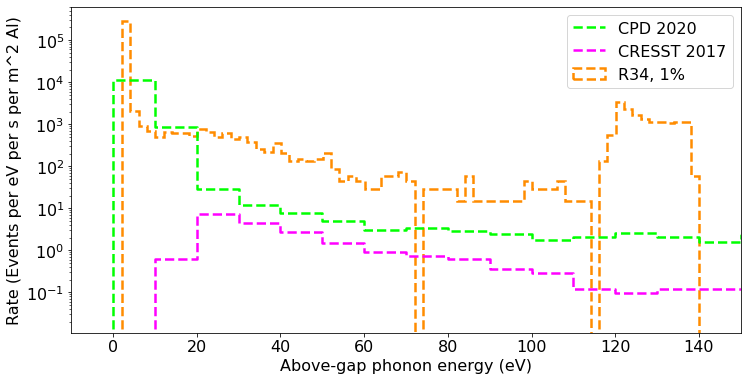

In [24]:
bin_width = 2
bins = np.arange(0.1, 155, bin_width)

ev_per_kev = 1e3

cpd_mass = 0.0106
cpd_surface_area = 45.6 * (0.01)**2
cpd_coverage_percent = 2
cpd_coverage = cpd_surface_area * cpd_coverage_percent * 0.01
seconds_per_day = 60 * 60 * 24
#print(seconds_per_day)
ev_per_kev = 1e3
extra_t_cpd = 6
cpd_scale = extra_t_cpd * cpd_mass/(seconds_per_day * ev_per_kev * cpd_coverage)
print(cpd_scale)

cresst_mass = 0.024
cresst_surface_area = 6 * (0.05*0.05)
cresst_coverage = 5.7e-3 * (3.8e-3 - 0.85e-3) #this is light detector I think
#cresst_coverage = 1.75e-3 * 4e-3 #same as francesca detector
#cresst_coverage = 7.5e-3 * 
extra_t_cresst = 50
cresst_scale = extra_t_cresst * cresst_mass/(seconds_per_day * ev_per_kev * cresst_coverage)
print(cresst_scale)

print(" ")
print("CRESST coverage: " + str(cresst_coverage) + " m^2")
print("CPD coverage: " + str(cpd_coverage) + " m^2")
print("1% coverage: " + str(coverage_benchmark) + " m^2")

coverage_1pc = coverage_benchmark
extra_t_1pc = 2
scale_1pc = extra_t_1pc/(bin_width * livetime_1pc * coverage_1pc)
weights_1pc = np.ones_like(onepc_energies) * scale_1pc

plt.step(cpd_bins[:-1]*1e3, cpd_heights*cpd_scale, label = "CPD 2020",
         color = 'lime', linestyle = '--', linewidth = 2.5)
plt.step(cresst_bins*1e3, cresst_heights*cresst_scale, label = "CRESST 2017", 
         color = 'magenta', linestyle = '--', linewidth = 2.5)

plt.hist(onepc_energies, bins=bins, weights=weights_1pc, label = "R34, 1%", 
         histtype = 'step', linestyle = '--', linewidth = 2.5, color = 'darkorange')

plt.yscale('log')
plt.ylabel(r"Rate (Events per eV per s per m^2 Al)")
plt.xlabel("Above-gap phonon energy (eV)")
plt.xlim(-10, 150)
plt.legend()

#plt.savefig("SimulatedSpectrum_3.pdf", bbox_inches='tight')

plt.show()

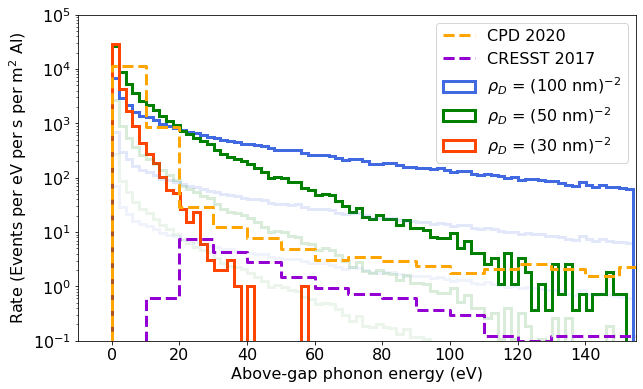

In [25]:
font = {'family': 'normal',
       'weight': 'normal',
       'size': 16}
plt.rc('font', **font)
mpl.rcParams['figure.figsize'] = [10, 6]

bin_width = 2
bins = np.arange(0.1, 155, bin_width)

weight_100 = rate_100/(bin_width * len(energies_100) * coverage_benchmark)
weight_50 = rate_50/(bin_width * len(energies_50) * coverage_benchmark)
weight_30 = rate_30/(bin_width * len(energies_30) * coverage_benchmark)

weights_100 = np.ones_like(energies_100) * weight_100
weights_50 = np.ones_like(energies_50) * weight_50
weights_30 = np.ones_like(energies_30) * weight_30

plt.hist(energies_100, bins = bins, histtype = 'step', weights = weights_100,
         linewidth = 3, color = 'royalblue', label = r"$\rho_D$ = (100 nm)$^{-2}$")
plt.hist(energies_50, bins = bins, histtype = 'step', weights = weights_50,
         linewidth = 3, color = 'green', label = r"$\rho_D$ = (50 nm)$^{-2}$")
plt.hist(energies_30, bins = bins, histtype = 'step', weights = weights_30,
         linewidth = 3, color = 'orangered', label = r"$\rho_D$ = (30 nm)$^{-2}$")
#plt.hist(energies_100, bins = bins, histtype = 'step', weights = weights_100*2e-2,
#        linewidth = 2, linestyle = ':', color = 'royalblue')#, label = r"$\rho_D$ = (100 nm)$^{-2}$ x0.3%")




plt.hist(energies_100, bins = bins, histtype = 'step', weights = weights_100*1e-1,
         linewidth = 3, color = 'royalblue', alpha = 0.15)#, label = r"$\rho_D$ = (100 nm)$^{-2}$")
plt.hist(energies_50, bins = bins, histtype = 'step', weights = weights_50*1e-1,
         linewidth = 3, color = 'green', alpha = 0.15)#, label = r"$\rho_D$ = (50 nm)$^{-2}$")

plt.hist(energies_100, bins = bins, histtype = 'step', weights = weights_100*1e-2,
         linewidth = 3, color = 'royalblue', alpha = 0.075)#, label = r"$\rho_D$ = (100 nm)$^{-2}$")
plt.hist(energies_50, bins = bins, histtype = 'step', weights = weights_50*1e-2,
         linewidth = 3, color = 'green', alpha = 0.075)#, label = r"$\rho_D$ = (50 nm)$^{-2}$")





plt.step(cpd_bins[:-1]*1e3, cpd_heights*cpd_scale, label = "CPD 2020",
         color = 'orange', linestyle = '--', linewidth = 3.0)
plt.step(cresst_bins*1e3, cresst_heights*cresst_scale, label = "CRESST 2017", 
         color = 'darkviolet', linestyle = '--', linewidth = 3.0)

#plt.hist(onepc_energies, bins=bins[:50], weights=weights_1pc, label = "R34, 1%", 
#         histtype = 'step', linestyle = '--', linewidth = 2.0, color = 'darkorange')

plt.yscale('log')
plt.ylabel(r"Rate (Events per eV per s per m$^2$ Al)")
plt.xlabel("Above-gap phonon energy (eV)")
plt.xlim(-10, 155)
plt.legend()
plt.ylim(0.1, 1e5)

#plt.savefig("SimulatedSpectrum_4.pdf", bbox_inches='tight')

plt.show()